In [63]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt

In [64]:
from PIL import Image
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot as plt
import lime
from lime import lime_image
import shap
from tensorflow.keras.applications import VGG16  # Replace with your pre-trained model if not VGG16
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import cv2  # Import cv2 for image processing
from matplotlib import pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from skimage.transform import resize
from tensorflow.keras.models import Model

In [65]:
dataset_dir = "./tuberculosis-tb-chest-xray-dataset"
normal_dir = os.path.join(dataset_dir, "Normal")
tuberculosis_dir = os.path.join(dataset_dir, "Tuberculosis")

In [66]:
def preprocess_images(image_dir, label):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path)
            image = image.convert("RGB")    # Convert grayscale to RGB
            image = image.resize((256, 256))  # Resize images to 256x256 pixels
            image = np.array(image) / 255.0   # Normalize pixel values to [0, 1]
            images.append(image)
            labels.append(label)
    return images, labels

In [67]:
# Load and preprocess normal images
normal_images, normal_labels = preprocess_images(normal_dir, label=0)

In [68]:
tuberculosis_images, tuberculosis_labels = preprocess_images(tuberculosis_dir, label=1)


In [69]:
# Combine normal and tuberculosis images
images = normal_images + tuberculosis_images
labels = normal_labels + tuberculosis_labels

In [70]:
images = np.array(images)
labels = np.array(labels)

In [71]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [72]:
print("Train images shape:", train_images.shape)
print("Test images shape:", test_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (3360, 256, 256, 3)
Test images shape: (840, 256, 256, 3)
Train labels shape: (3360,)
Test labels shape: (840,)


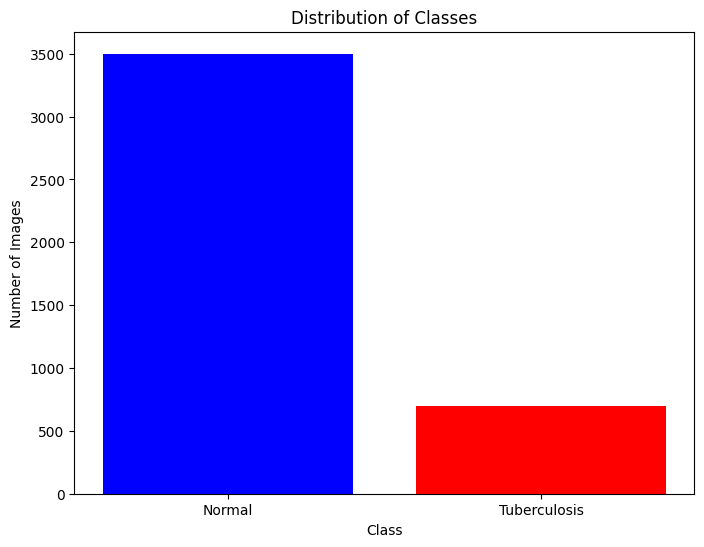

In [11]:
# Visualize the distribution of classes
plt.figure(figsize=(8, 6))
plt.bar(["Normal", "Tuberculosis"], [len(normal_images), len(tuberculosis_images)], color=['blue', 'red'])
plt.title("Distribution of Classes")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

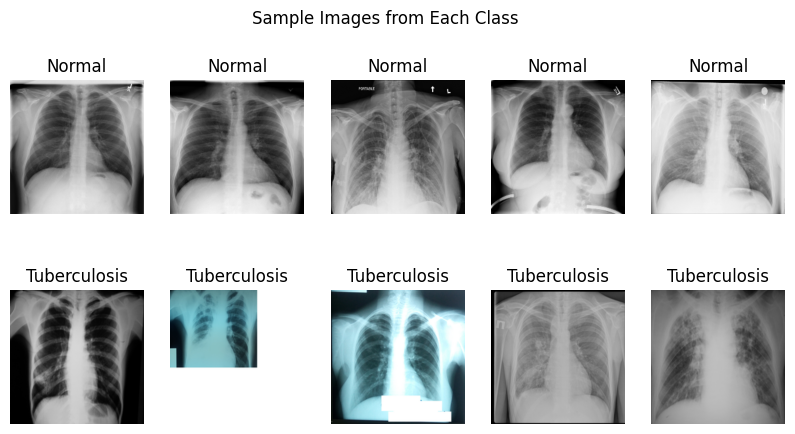

In [73]:
plt.figure(figsize=(10, 5))
for i in range(5):
    # Display Normal images
    plt.subplot(2, 5, i+1)
    plt.imshow(normal_images[random.randint(0, len(normal_images) - 1)])
    plt.title("Normal")
    plt.axis("off")

    # Display Tuberculosis images
    plt.subplot(2, 5, i+6)
    plt.imshow(tuberculosis_images[random.randint(0, len(tuberculosis_images) - 1)])
    plt.title("Tuberculosis")
    plt.axis("off")

plt.suptitle("Sample Images from Each Class")
plt.show()

In [74]:
def create_alexnet_model(input_shape, num_classes=1):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(6, (5, 5), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(16, (5, 5), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(120, activation='relu')(x)
    x = layers.Dense(84, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)  # Output layer

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Example usage:
input_shape = (256, 256, 3)  # Example input shape
num_classes = 1  # Example number of classes for binary classification
alexnet_model = create_alexnet_model(input_shape, num_classes)

# Print model summary
alexnet_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 252, 252, 6)       456       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 126, 126, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 122, 122, 16)      2416      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 61, 61, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 59536)             0   

In [75]:
alexnet_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [76]:
history = alexnet_model.fit(train_images, train_labels,
                          epochs=12,
                          batch_size=32,
                          validation_data=(test_images, test_labels))

Epoch 1/12
105/105 [==============================] - 39s 309ms/step - loss: 0.3186 - accuracy: 0.8994 - val_loss: 0.1133 - val_accuracy: 0.9560
Epoch 2/12
105/105 [==============================] - 15s 146ms/step - loss: 0.1066 - accuracy: 0.9598 - val_loss: 0.0937 - val_accuracy: 0.9643
Epoch 3/12
105/105 [==============================] - 15s 143ms/step - loss: 0.1014 - accuracy: 0.9667 - val_loss: 0.1009 - val_accuracy: 0.9607
Epoch 4/12
105/105 [==============================] - 15s 140ms/step - loss: 0.0569 - accuracy: 0.9771 - val_loss: 0.0747 - val_accuracy: 0.9774
Epoch 5/12
105/105 [==============================] - 15s 139ms/step - loss: 0.0301 - accuracy: 0.9914 - val_loss: 0.0648 - val_accuracy: 0.9821
Epoch 6/12
105/105 [==============================] - 15s 140ms/step - loss: 0.0181 - accuracy: 0.9929 - val_loss: 0.0720 - val_accuracy: 0.9786
Epoch 7/12
105/105 [==============================] - 15s 140ms/step - loss: 0.0112 - accuracy: 0.9958 - val_loss: 0.0804 - val_ac

In [22]:
model_path = "tuberculosis_model.h5"
alexnet_model.save(model_path)

In [23]:
predictions = alexnet_model.predict(test_images)

# Print the shape of the predictions array
print("Shape of predictions array:", predictions.shape)

27/27 [==============================] - 1s 25ms/step
Shape of predictions array: (840, 1)


In [24]:
model_path = "./models/tuberculosis_model.h5"
alexnet_model = tf.keras.models.load_model(model_path)

In [37]:
def preprocess(image_path):
    img = Image.open(image_path)
    img = img.convert("RGB")
    image = img.resize((256, 256))
    image = np.array(image, dtype=np.float32) / 255.0
    return image

In [40]:
def GradCAM(model, image, interpolant=0.5, plot_results=True):
    assert (interpolant > 0 and interpolant < 1), "Heatmap Interpolation Must Be Between 0 - 1"

    # Preprocess image and make prediction using our model
    original_img = np.asarray(image, dtype=np.float32)
    img = np.expand_dims(original_img, axis=0)

    # Predict
    prediction = model.predict(img)
    prediction_idx = np.argmax(prediction)
    print(prediction)

    # Find the last convolutional layer
    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer
            break

    if last_conv_layer is None:
        raise ValueError("No convolutional layer found in the model.")

    # Create a model to extract feature maps and predictions
    gradient_model = Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])

    # Compute gradient of top predicted class
    with tf.GradientTape() as tape:
        conv2d_out, prediction = gradient_model(img)
        loss = prediction[:, prediction_idx]

    gradients = tape.gradient(loss, conv2d_out)

    output = conv2d_out[0]
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    activation_map = cv2.resize(activation_map.numpy(), (original_img.shape[1], original_img.shape[0]))
    activation_map = np.maximum(activation_map, 0)
    activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
    activation_map = np.uint8(255 * activation_map)
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    original_img = np.uint8((original_img - original_img.min()) / (original_img.max() - original_img.min()) * 255)
    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    if plot_results:
        plt.imshow(np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant)))
    else:
        return cvt_heatmap

1/1 [==============================] - 0s 28ms/step
[[7.3939977e-06]]


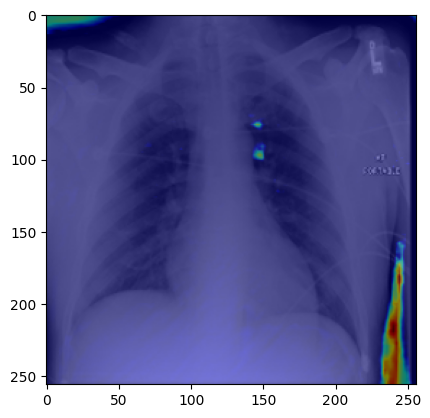

In [42]:
test_image = preprocess("./test/normal.png")
GradCAM(alexnet_model, test_image, plot_results=True)

In [62]:
test_image = preprocess("./test/tb.png")
# Preprocess image and make prediction using our model
original_img = np.asarray(test_image, dtype=np.float32)
img = np.expand_dims(original_img, axis=0)

# Predict
prediction = alexnet_model.predict(img)

if(prediction[0] > 0.90):
    print("Positive Case")
else:
    print("Normal Case")

1/1 [==============================] - 0s 30ms/step
Positive Case
